In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Import manythings.org Anki data
English/French data obtained from http://www.manythings.org/anki/

Specifically: http://www.manythings.org/anki/fra-eng.zip

In [2]:
NUM_EXAMPLES = 200000
data_fra = []
with open('fra.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_fra) < NUM_EXAMPLES:
            data_fra.append(line)
        else:
            break

In [3]:
import numpy as np
i = np.random.randint(len(data_fra))
print(data_fra[i])

No one is unbeatable.	Personne n'est imbattable.	CC-BY 2.0 (France) Attribution: tatoeba.org #2091140 (CK) & #2101888 (sacredceltic)



In [4]:
# check the structure
split_fra = np.array([s.split('\t') for s in data_fra])
print(np.array(split_fra).shape)

split_fra = split_fra[:,:-1]
print(np.array(split_fra).shape)

(190206, 3)
(190206, 2)


In [5]:
eng_fra = split_fra[:,0]
print(eng_fra[0:3])
fra_fra = split_fra[:,1]
print(fra_fra[0:3])

['Go.' 'Go.' 'Go.']
['Va !' 'Marche.' 'Bouge !']


### Import other Anki data
* https://ankiweb.net/shared/info/3249357849 - Intermediate French
* https://ankiweb.net/shared/info/468622242  - 5000 most common french words

These decks were downloaded from the links listed, then exported to .txt files by the Anki program. 


In [6]:


NUM_EXAMPLES = 200000
data_int = []
with open('intermediate french.txt', 'r', encoding='utf8') as f:
    counter = 1
    for line in f.readlines():
        if len(data_int) < NUM_EXAMPLES:
            if counter % 2 == 0:
                data_int.append(line)
            counter += 1
        else:
            break

In [7]:
# check the structure
split_int = np.array([s.split('\t') for s in data_int])
print(split_int[0:3])

[['Voluntary worker' 'Le bénévole\n']
 ['a guess' 'Une devinette\n']
 ['élu' 'elected\n']]


In [8]:
eng_int = split_int[:,0]
print(eng_int[0:3])
fra_int = split_int[:,1]
print(fra_int[0:5])

['Voluntary worker' 'a guess' 'élu']
['Le bénévole\n' 'Une devinette\n' 'elected\n'
 'se remettre de la soiree\n' 'aménager\n']


In [9]:


NUM_EXAMPLES = 200000
data_5000 = []
with open('5000 Most Common French Words.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_5000) < NUM_EXAMPLES:
            data_5000.append(line)
        else:
            break

In [10]:
# Sentences are stored in at positions 4 and 5 in each row
split_5000 = np.array([s.split('\t') for s in data_5000])
print(split_5000[2][5])

everything you dreamed about is available in town


In [11]:
eng_5000 = split_5000[:,5]
print(eng_5000[0:5])
fra_5000 = split_5000[:,4]
print(fra_5000[0:5])

['raise your hand one time' 'here, you are a public personality'
 'everything you dreamed about is available in town'
 'our city has a sense of community'
 'you should go to bed, you look wiped out']
['lève la main une fois' 'ici, vous avez une personnalité publique'
 'on a tout ce dont tu rêvais en ville'
 'notre ville a le sens de la communauté'
 '"tu devrais aller te coucher, tu as l\'air vanné"']


### Preprocess data
We currently have data from 4 sources, divided into English and french sentences.
* eng_fra and fra_fra (I realize this naming is a little confusing)
* eng_int and fra_int
* eng_23000 and fra_23000
* eng_5000 and fra_5000

In [12]:
eng_com = np.concatenate((eng_fra, eng_int, eng_5000)) 
fra_com = np.concatenate((fra_fra, fra_int, fra_5000))
print(eng_com.shape)
print(fra_com.shape)

(195708,)
(195708,)


In [13]:
print(eng_com[:3])
print(fra_com[:3])
print('...')
print(eng_com[-3:])
print(fra_com[-3:])

['Go.' 'Go.' 'Go.']
['Va !' 'Marche.' 'Bouge !']
...
['every American should also be scandalized'
 'a drug is more or less controlled'
 '"I\'m here to take a poll, for a poll"']
['chaque Américain devrait aussi être scandalisé'
 'une drogue est plus ou moins réglementée'
 'je viens sonder, pour une sondation']


In [14]:
import unicodedata
import re

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

In [15]:
eng = np.array([preprocess_sentence(s) for s in eng_com])
fra = np.array([preprocess_sentence(s) for s in fra_com])

eng_before_tokens = eng # this will be used when testing later
fra_before_tokens = fra # this will be used when testing later

eng = np.array(["<start> " + s + " <end>" for s in eng])
fra = np.array(["<start> " + s + " <end>" for s in fra])





In [16]:
fra_lengths = np.array([len(s.split()) for s in fra])
mask = fra_lengths <= 60
eng = eng[mask]
fra = fra[mask]

In [17]:
print(eng[:3])
print(fra[:3])
print('...')
print(eng[-3:])
print(fra[-3:])

['<start> go . <end>' '<start> go . <end>' '<start> go . <end>']
['<start> va ! <end>' '<start> marche . <end>' '<start> bouge ! <end>']
...
['<start> every american should also be scandalized <end>'
 '<start> a drug is more or less controlled <end>'
 "<start> i'm here to take a poll , for a poll <end>"]
['<start> chaque americain devrait aussi etre scandalise <end>'
 '<start> une drogue est plus ou moins reglementee <end>'
 '<start> je viens sonder , pour une sondation <end>']


In [18]:
toker_fra = tf.keras.preprocessing.text.Tokenizer(filters= '')
toker_fra.fit_on_texts(fra)
fra_tokens = toker_fra.texts_to_sequences(fra)

num_fra_tokens = len(toker_fra.word_index) + 1

print(num_fra_tokens)


29015


In [19]:
toker_eng = tf.keras.preprocessing.text.Tokenizer(filters= '')
toker_eng.fit_on_texts(eng)
eng_tokens = toker_eng.texts_to_sequences(eng)

num_eng_tokens = len(toker_eng.word_index) + 1

print(num_eng_tokens)

16950


In [20]:
indices = np.random.randint(0, len(fra), 3)
for i in indices:
    print("English phrase: ", eng[i])
    print("English token sequence: ", eng_tokens[i])
    print("French phrase: ", fra[i])
    print("French token sequence: ", fra_tokens[i], '\n')

English phrase:  <start> i betrayed you . <end>
English token sequence:  [1, 4, 1635, 5, 3, 2]
French phrase:  <start> je vous ai trahi . <end>
French token sequence:  [1, 4, 9, 105, 2928, 3, 2] 

English phrase:  <start> he tried to attract her attention . <end>
English token sequence:  [1, 15, 335, 6, 5282, 63, 793, 3, 2]
French phrase:  <start> il a cherche a attirer son attention . <end>
French token sequence:  [1, 15, 6, 796, 6, 5699, 58, 477, 3, 2] 

English phrase:  <start> if i had enough money , i'd buy this . <end>
English token sequence:  [1, 70, 4, 64, 200, 118, 21, 109, 207, 17, 3, 2]
French phrase:  <start> si j'avais assez d'argent , je l'acheterais . <end>
French token sequence:  [1, 48, 273, 183, 237, 19, 4, 6752, 3, 2] 



In [21]:
padded_fra_tokens = np.array(tf.keras.preprocessing.sequence.pad_sequences(fra_tokens, padding = 'post'))
padded_eng_tokens = np.array(tf.keras.preprocessing.sequence.pad_sequences(eng_tokens, padding = 'post'))


fra_input_length = len(padded_fra_tokens[0]) - 1 # -1 because french inputs get shortened by one in the training loop
eng_input_length = len(padded_eng_tokens[0])

print("Length of padded English sequences: ", eng_input_length)
print("Length (adjusted) of padded French sequences: ", fra_input_length)

Length of padded English sequences:  54
Length (adjusted) of padded French sequences:  58


In [22]:
eng_lengths = [len(s) for s in eng_tokens]
eng_index = np.argmax(eng_lengths)
print(eng[eng_index])
print(fra[eng_index])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> il est peut etre impossible d'obtenir un corpus completement denue de fautes , etant donnee la nature de ce type d'entreprise collaborative . cependant , si nous encourageons les membres a produire des phrases dans leurs propres langues plutot que d'experimenter dans les langues qu'ils apprennent , nous pourrions etre en mesure de reduire les erreurs . <end>


In [25]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(padded_eng_tokens, padded_fra_tokens, test_size = 0.025)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.05)

print(len(X_train))
print(len(X_val))
print(len(X_test))


training = tf.data.Dataset.from_tensor_slices((X_train,y_train))
validation = tf.data.Dataset.from_tensor_slices((X_val,y_val))

181273
9541
4893


In [26]:
batch_size = 32
training = training.batch(batch_size)
validation = validation.batch(batch_size)



print(training.element_spec)
print(validation.element_spec)


(TensorSpec(shape=(None, 54), dtype=tf.int32, name=None), TensorSpec(shape=(None, 59), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 54), dtype=tf.int32, name=None), TensorSpec(shape=(None, 59), dtype=tf.int32, name=None))


### The translators
We will train 3 different machines. All 3 share the same basic design:
* English sentences and French sentences are seperately passed into different embedding layers.
* The outputs of the English embedding layer (which are sequences of embedded word tokens) are passed through 3 recurrent layers.
* The important output of this is the recorded states (or state) coming out of the last layer.
* The output of the French embedding layer is then passed through 3 recurrent layers, where the first is also given the states output by the 3 emebedding layers used on the English sentence.
* The output of the final French recurrent layer is then passed through a dense layer.
* The final output is is then a sequence of sequences, where the outer sequence corresponds to a sequence of French words, and the inner sequences are supposed to correspond to (logit) probabilities of individual French words.

#### Machine T1
* Recurrent layers are LSTM layers.
* Each French LSTM layer is given the final hidden and cell states output by the final English LSTM layer.

In [27]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, GRU


embedding_dim = 24

def translator_1():
    eng_inputs = Input(shape=(eng_input_length))
    e = Embedding(input_dim = num_eng_tokens, output_dim = embedding_dim, mask_zero = True)(eng_inputs)
    e, state_h, state_c = LSTM(512, return_state = True, return_sequences = True)(e)
    e, state_h, state_c = LSTM(512, return_state = True, return_sequences = True)(e, initial_state = [state_h, state_c])
    e, state_h, state_c = LSTM(512, return_state = True)(e, initial_state = [state_h, state_c])
    
    fra_inputs = Input(shape = (fra_input_length,), batch_size = None)
    f = Embedding(input_dim = num_fra_tokens, output_dim = embedding_dim, mask_zero = True)(fra_inputs)
    f_seq = LSTM(512, return_sequences = True, return_state = False)(f, initial_state = [state_h, state_c])
    f_seq = LSTM(512, return_sequences = True, return_state = False)(f_seq, initial_state = [state_h, state_c])
    f_seq = LSTM(512, return_sequences = True, return_state = False)(f_seq, initial_state = [state_h, state_c])
    output = Dense(num_fra_tokens, activation = None)(f_seq)
    model = tf.keras.Model(inputs = [eng_inputs, fra_inputs], outputs = output)
    
    return model

In [28]:
T_1 = translator_1()
print(T_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 54, 24)       406800      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 54, 512), (N 1099776     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 58)]         0                                            
______________________________________________________________________________________________

#### Machine T2
* Like T1, except the 1st French Embedding layer passes its hidden and cell states to the 2nd, and the 2nd then passes its hidden and cell states to the 3rd. 

In [29]:
def translator_2():
    eng_inputs = Input(shape=(eng_input_length))
    e = Embedding(input_dim = num_eng_tokens, output_dim = embedding_dim, mask_zero = True)(eng_inputs)
    e, state_h, state_c = LSTM(512, return_state = True, return_sequences = True)(e)
    e, state_h, state_c = LSTM(512, return_state = True, return_sequences = True)(e, initial_state = [state_h, state_c])
    e, state_h, state_c = LSTM(512, return_state = True)(e, initial_state = [state_h, state_c])
    
    fra_inputs = Input(shape = (fra_input_length,), batch_size = None)
    f = Embedding(input_dim = num_fra_tokens, output_dim = embedding_dim, mask_zero = True)(fra_inputs)
    f_seq, state_h, state_c = LSTM(512, return_sequences = True, return_state = True)(f, initial_state = [state_h, state_c])
    f_seq, state_h, state_c = LSTM(512, return_sequences = True, return_state = True)(f_seq, initial_state = [state_h, state_c])
    f_seq, state_h, state_c = LSTM(512, return_sequences = True, return_state = True)(f_seq, initial_state = [state_h, state_c])
    output = Dense(num_fra_tokens, activation = None)(f_seq)
    model = tf.keras.Model(inputs = [eng_inputs, fra_inputs], outputs = output)
    
    return model

In [30]:
T_2 = translator_2()
print(T_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 54, 24)       406800      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 54, 512), (N 1099776     embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 58)]         0                                            
____________________________________________________________________________________________

#### Machine T3
* Like T1 except using GRU layers. 
* A consequence is that each recurrent layer only returns a single state, not both hidden and cell states.

In [31]:
def translator_3():
    eng_inputs = Input(shape=(eng_input_length))
    e = Embedding(input_dim = num_eng_tokens, output_dim = embedding_dim, mask_zero = True)(eng_inputs)
    e, state = GRU(512, return_state = True, return_sequences = True)(e)
    e, state = GRU(512, return_state = True, return_sequences = True)(e, initial_state = [state])
    e, state = GRU(512, return_state = True)(e, initial_state = [state])
    
    fra_inputs = Input(shape = (fra_input_length,), batch_size = None)
    f = Embedding(input_dim = num_fra_tokens, output_dim = embedding_dim, mask_zero = True)(fra_inputs)
    f_seq = GRU(512, return_sequences = True, return_state = False)(f, initial_state = [state])
    f_seq = GRU(512, return_sequences = True, return_state = False)(f_seq, initial_state = [state])
    f_seq = GRU(512, return_sequences = True, return_state = False)(f_seq, initial_state = [state])
    output = Dense(num_fra_tokens, activation = None)(f_seq)
    model = tf.keras.Model(inputs = [eng_inputs, fra_inputs], outputs = output)
    
    return model

In [32]:
T_3 = translator_3()
print(T_3.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 54, 24)       406800      input_5[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       [(None, 54, 512), (N 826368      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 58)]         0                                            
____________________________________________________________________________________________

In [33]:
losser = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

@tf.function
def grad(model, eng_in, fra_in, fra_out):
    with tf.GradientTape() as tape:
        output = model([eng_in, fra_in])
        loss = losser(fra_out,output)
    return loss, tape.gradient(loss, model.trainable_variables)

In [34]:
# get the numerical token for the <end> token
import json 
end_index = json.loads(toker_fra.get_config()['word_index']).get('<end>')


def format_fra_in_out(x):
    return tf.convert_to_tensor(np.where(x[:,:-1]==end_index, 0, x[:,:-1]), dtype = 'int32') , x[:,1:]

In [35]:
import time

opt = tf.keras.optimizers.Adam(learning_rate=0.0003)


def train_translator(model, num_epochs):
    start_time = time.time()
    val_loss_results = []
    train_loss_results = []
    for epoch in range(num_epochs):
        train_loss_avg = tf.keras.metrics.Mean()
        val_loss_avg = tf.keras.metrics.Mean()
        for x, y in training.shuffle(buffer_size = 10000):
            #print("epoch {}, new batch started".format(epoch))
            fra_in, fra_out = format_fra_in_out(y)
            loss, grads = grad(model, x, fra_in, fra_out)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            train_loss_avg(loss)

        for x, y in validation:
            fra_in, fra_out = format_fra_in_out(y)
            loss, grads = grad(model, x, fra_in, fra_out)
            val_loss_avg(loss)

        val_loss_results.append(val_loss_avg.result())
        train_loss_results.append(train_loss_avg.result())
        print("Time at epoch {} :{:.3f}".format(epoch, time.time() - start_time))
        print("Val loss: {:.3f}".format(val_loss_avg.result()))

    print("Duration :{:.3f}".format(time.time() - start_time))
    return model, train_loss_results, val_loss_results

We'll train our machines for 10 epochs. This took a few hours on my hardware (Nvidia GTX 1060 6GB). Rather than training, pretrained weights can be loaded a few cells down (provided you have the corresponding files).

In [36]:
T_1, train_loss_results_1, val_loss_results_1 = train_translator(T_1, 10)

Time at epoch 0 :903.223
Val loss: 6.611
Time at epoch 1 :1778.990
Val loss: 3.915
Time at epoch 2 :2651.727
Val loss: 1.572
Time at epoch 3 :3527.075
Val loss: 0.593
Time at epoch 4 :4411.180
Val loss: 0.395
Time at epoch 5 :5287.660
Val loss: 0.338
Time at epoch 6 :6167.932
Val loss: 0.312
Time at epoch 7 :7041.293
Val loss: 0.297
Time at epoch 8 :7916.117
Val loss: 0.287
Time at epoch 9 :8790.601
Val loss: 0.279
Duration :8790.601


In [37]:
T_2, train_loss_results_2, val_loss_results_2 = train_translator(T_2, 10)

Time at epoch 0 :899.381
Val loss: 5.928
Time at epoch 1 :1779.973
Val loss: 3.175
Time at epoch 2 :2655.477
Val loss: 1.012
Time at epoch 3 :3532.321
Val loss: 0.302
Time at epoch 4 :4405.051
Val loss: 0.160
Time at epoch 5 :5278.802
Val loss: 0.116
Time at epoch 6 :6154.760
Val loss: 0.097
Time at epoch 7 :7029.896
Val loss: 0.087
Time at epoch 8 :7900.216
Val loss: 0.080
Time at epoch 9 :8773.949
Val loss: 0.073
Duration :8773.949


In [38]:
T_3, train_loss_results_3, val_loss_results_3 = train_translator(T_3, 10)

Time at epoch 0 :858.969
Val loss: 6.113
Time at epoch 1 :1696.004
Val loss: 3.421
Time at epoch 2 :2536.342
Val loss: 1.272
Time at epoch 3 :3373.557
Val loss: 0.550
Time at epoch 4 :20225.366
Val loss: 0.396
Time at epoch 5 :21046.988
Val loss: 0.347
Time at epoch 6 :21874.000
Val loss: 0.321
Time at epoch 7 :22687.138
Val loss: 0.306
Time at epoch 8 :23503.649
Val loss: 0.295
Time at epoch 9 :24318.705
Val loss: 0.289
Duration :24318.706


In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_losses(train_loss_results, val_loss_results, name = ''):
    plt.style.use('ggplot')

    epochs = range(0, len(train_loss_results))

    plt.figure(figsize=(14,5))
    plt.plot(epochs, val_loss_results, marker='.', label='Validation loss')
    plt.plot(epochs, train_loss_results, marker='.', label='Training loss')
    plt.title('Training and validation loss {}'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    #plt.ylim(0, 8);

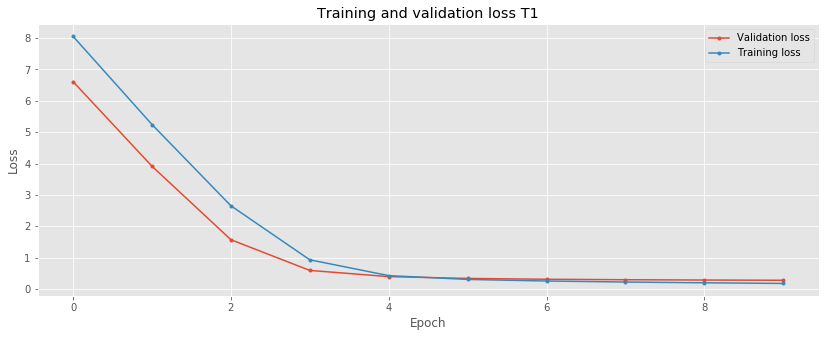

In [40]:
plot_losses(train_loss_results_1, val_loss_results_1, 'T1')

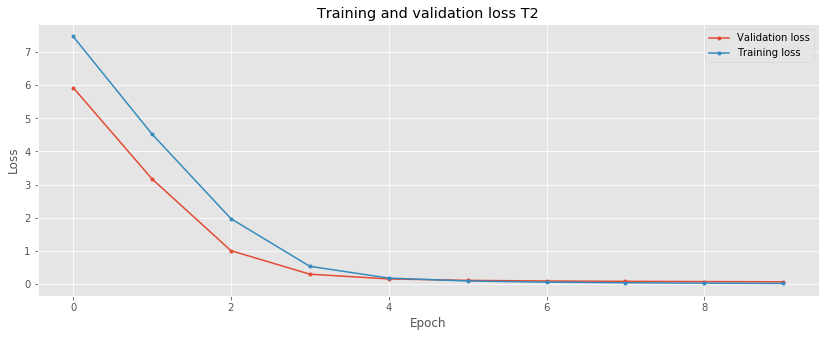

In [41]:
plot_losses(train_loss_results_2, val_loss_results_2, 'T2')

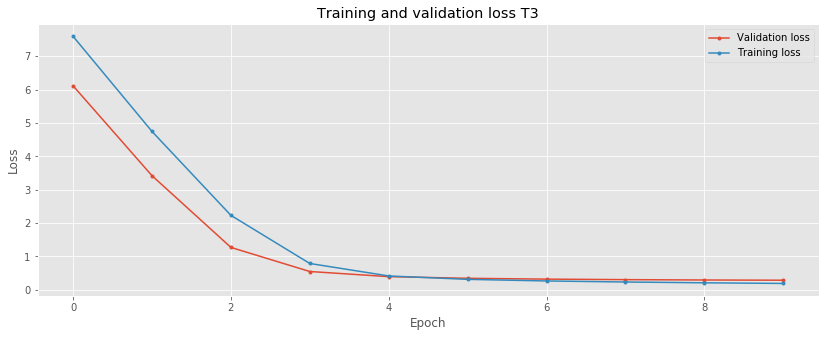

In [42]:
plot_losses(train_loss_results_3, val_loss_results_3, 'T3')

### Saving weights

In [43]:
T_1.save_weights('saved_weights/T1_weights')
T_2.save_weights('saved_weights/T2_weights')
T_3.save_weights('saved_weights/T3_weights')

In [44]:
# load weights if desired

#T_1 = translator_1()
#T_1.load_weights('saved_weights/T1_weights')

#T_2 = translator_1()
#T_2.load_weights('saved_weights/T2_weights')

#T_3 = translator_1()
#T_3.load_weights('saved_weights/T3_weights')

### Using the translators

In [45]:

def translate(models, strings):
    translations = []
    for T in models:
        sentences = []
        for eng_string in strings:
            eng_string = preprocess_sentence(eng_string)
            eng_string = "<start> " + eng_string + " <end>"
            eng_string = toker_eng.texts_to_sequences([eng_string])
            eng_string = np.array(tf.keras.preprocessing.sequence.pad_sequences(eng_string, padding = 'post', maxlen = eng_input_length))
            eng_string = tf.convert_to_tensor(np.array(eng_string, dtype = 'int32'))
            word_string = [1]
            word_string = tf.keras.preprocessing.sequence.pad_sequences([word_string], padding = 'post', maxlen = fra_input_length)
            #print(eng_string)
            #print(word_string)
            for i in range(fra_input_length - 1):
                input_string = tf.convert_to_tensor(np.array(word_string), dtype = 'int32')
                #print(input_string)
                output = T([eng_string, input_string])
                #print(len(output[0]))
                #print(toker_fra.sequences_to_texts([[np.argmax(output[0][i])]]))
                #print(output[0][i])
                #print(np.argmax(output[0][i]))
                word_string[0][i+1] = np.argmax(output[0][i])
                #print(toker_fra.sequences_to_texts([[np.argmax(output[0][i])]]))
                if np.argmax(output[0][i]) == end_index:
                             break
            new_sentence = ' '.join(toker_fra.sequences_to_texts(word_string)[0].split()[1:-1])
            sentences.append(new_sentence) 
        translations.append(sentences)    
    return translations 
    


#### Translating some simple sentences

In [46]:
simple_sentences = ['I am very busy.', 
                    'The dog has a ball.', 
                    'Tom goes into the city.', 
                    'I like to eat apples!', 
                    'In the city the men wore black suits and blue ties.']
translations = translate([T_1,T_2,T_3], simple_sentences)

for i in range(3):
    print('T{}'.format(i + 1))
    for j in range(len(simple_sentences)):
        print('Original: {}'.format(simple_sentences[j]))
        print('Translation: {}'.format(translations[i][j]))
        print('')
    print('')

T1
Original: I am very busy.
Translation: je suis tres occupe .

Original: The dog has a ball.
Translation: le chien a une pomme .

Original: Tom goes into the city.
Translation: tom se precipita en ville .

Original: I like to eat apples!
Translation: j'aime manger des pommes .

Original: In the city the men wore black suits and blue ties.
Translation: la ville de la population entre les dents et les refugies sans fer .


T2
Original: I am very busy.
Translation: j'adore

Original: The dog has a ball.
Translation: l'equipe

Original: Tom goes into the city.
Translation: j'adore

Original: I like to eat apples!
Translation: j'adore

Original: In the city the men wore black suits and blue ties.
Translation: devenir


T3
Original: I am very busy.
Translation: je suis tres occupe .

Original: The dog has a ball.
Translation: le chien a une balle .

Original: Tom goes into the city.
Translation: tom va dans le bureau .

Original: I like to eat apples!
Translation: j'aimerais manger de gate

#### Translating some random sentences from the corpus

In [47]:
indices = np.random.randint(0, len(eng) -1, 5)
#print(indices)
padded_eng_sample = np.array(padded_eng_tokens)[indices]
#print(eng_sample)
fra_sample = np.array(fra)[indices]
#print(fra_sample)
fra_sample_tokens = toker_fra.texts_to_sequences(fra_sample)
#print(ger_sample_tokens)
padded_fra_sample = np.array(tf.keras.preprocessing.sequence.pad_sequences(fra_sample_tokens, padding = 'post'))
#print(padded_ger_sample)

sample_dataset = tf.data.Dataset.from_tensor_slices((padded_eng_sample, padded_fra_sample))


sample_dataset = sample_dataset.batch(1) # to play nicely with the EndEmbedding function

In [48]:
translations = translate([T_1,T_2,T_3], eng_before_tokens[indices])

for i in range(3):
    print('T{}'.format(i+1))
    for j in range(len(indices)):
        print('Original: {}'.format(eng_before_tokens[indices][j]))
        print('Reference Translation: {}'.format(fra_before_tokens[indices][j]))
        print('Machine translation: {}'.format(translations[i][j]))
        print('')
    print('')

   

T1
Original: can you afford it ?
Reference Translation: en as tu les moyens ?
Machine translation: pouvez vous nous le prevenir ?

Original: i was born there .
Reference Translation: j'y suis ne .
Machine translation: je suis nee .

Original: a committee is a group of people who individually can do nothing , but who , as a group , can meet and decide that nothing can be done .
Reference Translation: un comite est un groupe de gens qui ne peuvent rien faire individuellement mais qui peuvent tenir des reunions en tant que groupe et parvenir a la decision qu'on ne peut rien faire .
Machine translation: une nouvelle de nouveau de nouveau qui sont un peu qui ne peut rien faire , mais nous avons des choses qui ne peuvent pas faire des gens , mais on peut faire ca .

Original: the band played a march .
Reference Translation: la fanfare a joue une marche .
Machine translation: le comite a saute un jour .

Original: wait a little longer .
Reference Translation: attendez encore un peu !
Machine 

From the tests above, it seems that T1 does fairly well on very simple sentences, with T3 similar, though possibly somewhat worse. Both seem to fail for things more than a few words long, though the results seem to be at least vaguely related to the original. T2 on the other hand is terrible. This may be surprising, as T2 recorded significantly lower validation loss during training. What is happening? My theory is that the fact that T2 passes on the hidden and cell states of the French LSTM layers, rather than just using the state outputs of the English LSTM sequence, causes the machine to pay much more attention to the French sentence it is given than the English sentence. This works during training and validation because it is given both the English and the French reference translation. However, when the machine does translations 'in the wild' the French sentence it starts with is just the \<start\> token.

#### Calculating BLEU scores.
Finally, here are the BLEU scores for each translator calculated using the testing data set aside earlier. The results bear out the impressions from the previous tests.

In [49]:
eng_test = [' '.join(s.split()[1:-1]) for s in toker_eng.sequences_to_texts(X_test)]
fra_test = [' '.join(s.split()[1:-1]) for s in toker_fra.sequences_to_texts(y_test)]

# For BLEU score each sentence is matched to an array of reference translations (each of which is an array of words)
# Here we only have one reference per sentence, but it must be in its own array
references = [[s.split()] for s in fra_test] 

translations = translate([T_1,T_2,T_3], eng_test)

In [50]:
translations_1 = [s.split() for s in translations[0]]
translations_2 = [s.split() for s in translations[1]]
translations_3 = [s.split() for s in translations[2]]

In [52]:
from nltk.translate.bleu_score import corpus_bleu
score_1 = corpus_bleu(references, translations_1)
print('BLEU score T1: ', score_1)

score_2 = corpus_bleu(references, translations_2)
print('BLEU score T2: ',score_2)

score_3 = corpus_bleu(references, translations_3)
print('BLEU score T3: ',score_3)

BLEU score T1:  0.24915965127172907
BLEU score T2:  6.880856657558399e-235
BLEU score T3:  0.21128536657033686
